<a id="introduction"></a>

# PS2: Logistic Regression Classification of a Clinical Dataset
Can simple linear classifiers predict whether a heart-failure patient will survive based on routine clinical measurements? In this problem set, we address that question by training a Perceptron and a Logistic Regression classifier on a real clinical dataset of 299 patients.

We preprocess the data, visualize it with PCA, train both classifiers on the same train/test split, and compare their performance using confusion-matrix metrics. Work through the notebook, correct any issues, and answer the discussion questions at the end.

> **Learning Objectives:**
> 
> By the end of this problem set, you should be able to:
> 
> * **Preprocess clinical data for classification:** Recode binary features to $\{-1,1\}$, apply z-score normalization to continuous features, and split into training and test sets.
> * **Use PCA to visualize high-dimensional patient data:** Compute the covariance matrix, perform eigendecomposition, and project onto the top two principal components to assess class separability.
> * **Train, evaluate, and compare linear classifiers:** Fit perceptron and logistic regression models and assess accuracy, precision, and recall on the test set using confusion matrices.
___

<a id="setup"></a>

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.

In [1]:
include("Include.jl");

<a id="data"></a>

### Data
Next, let's load up the dataset that we will explore. The data for this lab was taken from this `2020` publication:
* [Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone." BMC Medical Informatics and Decision Making 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5](https://pubmed.ncbi.nlm.nih.gov/32013925/)

In this paper, the authors analyzed a dataset of 299 heart failure patients collected in 2015. The patients comprised 105 women and 194 men, aged between 40 and 95 years old. The dataset contains 13 features (a mixture of continuous and categorical data), which report clinical, body, and lifestyle information:
* Some features are binary: anemia, high blood pressure, diabetes, sex, and smoking status.
* The remaining features were continuous biochemical measurements, such as the level of the Creatinine phosphokinase (CPK) enzyme in the blood, the number of platelets, etc.
* The class (target) variable is encoded as a binary (boolean) death event: `1` if the patient died during the follow-up period, `0` if the patient did not die during the follow-up period.

We'll load this dataset as a [DataFrame instance](https://dataframes.juliadata.org/stable/) and store it in the `originaldataset::DataFrame` variable:

In [2]:
originaldataset = MyHeartDiseaseClinicalDataset(); # load the heart disease dataset

<a id="scaling"></a>

#### Data scaling
Our binary classification models require [a `Matrix`](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix-Tuple{UndefInitializer,%20Any,%20Any}), not [a `DataFrame`](https://dataframes.juliadata.org/stable/). We preprocess the data in three steps:

> __Data Preprocessing:__
> 
> * __Binary recoding:__ Convert categorical `0,1` data to `-1,1` where `0` maps to `-1` and `1` remains `1`.
> * __Z-score normalization:__ Apply [z-score scaling](https://en.wikipedia.org/wiki/Feature_scaling) to continuous features using $x^{\prime} = (x - \mu)/\sigma$ where $\mu$ is the mean and $\sigma$ is the standard deviation.
> * __Label retention:__ Keep the `death_event` label because the classifiers are supervised.

The preprocessed feature matrix is stored in `X::Matrix{Float64}`, while the label vector is stored in `y::Vector{Float64}`. We also keep the treated dataset in `dataset::DataFrame`.

In [3]:
(X, y, dataset) = let

    # convert 0,1 into -1,1
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :anaemia => ByRow(x -> (x==0 ? -1 : 1)) => :anaemia); # maps anaemia to -1,1
    transform!(treated_dataset, :diabetes => ByRow(x -> (x==0 ? -1 : 1)) => :diabetes); # maps diabetes to -1,1
    transform!(treated_dataset, :high_blood_pressure => ByRow(x -> (x==0 ? -1 : 1)) => :high_blood_pressure); # maps high_blood_pressure to -1,1
    transform!(treated_dataset, :sex => ByRow(x -> (x==0 ? -1 : 1)) => :sex); # maps sex to -1,1
    transform!(treated_dataset, :smoking => ByRow(x -> (x==0 ? -1 : 1)) => :smoking); # maps smoking to -1,1
    transform!(treated_dataset, :death_event => ByRow(x -> (x==0 ? -1 : 1)) => :death_event); # maps death_event to -1,1
    
    D = treated_dataset[:,1:end] |> Matrix; # build a data matrix from the DataFrame
    (number_of_examples, number_of_features) = size(D);

    # Which cols do we want to rescale?
    index_to_z_scale = [
        1 ; # 1 age
        3 ; # 2 creatinine_phosphokinase
        5 ; # 3 ejection_fraction
        7 ; # 4 platelets
        8 ; # 5 serum_creatinine
        9 ; # 6 serum_sodium
        12 ; # 7 time
    ];

    D̂ = copy(D);
    for i ∈ eachindex(index_to_z_scale)
        j = index_to_z_scale[i];
        μ = mean(D[:,j]); # compute the mean
        σ = std(D[:,j]); # compute std

        # rescale -
        for k ∈ 1:number_of_examples
            D̂[k,j] = (D[k,j] - μ)/σ; # z-scale the continuous features
        end
    end

    # split features and labels
    X = D̂[:,1:end-1]; # features
    y = D̂[:,end]; # labels (death_event)

    X, y, treated_dataset
end;

Now, let's form the centered data matrix $\tilde{\mathbf{X}}$ by subtracting the mean from each column (feature) of the data matrix $\mathbf{X}$. We store the centered data in the `X̃::Array{Float64,2}` variable:

In [4]:
 X̃ = let 
    r, c = size(X)
    m = mean(X, dims=1) |> vec # mean for each dimension
    ones_vector = ones(r)
    # Center the data by subtracting mean from each column
    # ⊗ (outer product) replicates the mean vector for each row
    X̃ = X .- ⊗(ones_vector, m); # the ⊗ operator is the outer product, which replicates the mean vector for each example, allowing us to subtract it from each row of X
end

299×12 Matrix{Float64}:
  1.19095    -0.862876   0.000165451  …   0.702341  -0.64214  -1.62678
 -0.490457   -0.862876   7.50206          0.702341  -0.64214  -1.60101
  0.350246   -0.862876  -0.449186         0.702341   1.35786  -1.58812
 -0.910808    1.13712   -0.485257         0.702341  -0.64214  -1.58812
  0.350246    1.13712   -0.434757        -1.29766   -0.64214  -1.57524
  2.452       1.13712   -0.551217     …   0.702341   1.35786  -1.57524
  1.19095     1.13712   -0.346124         0.702341  -0.64214  -1.54947
 -0.0701056   1.13712   -0.275011         0.702341   1.35786  -1.54947
  0.350246   -0.862876  -0.437849        -1.29766   -0.64214  -1.54947
  1.6113      1.13712   -0.47289          0.702341   1.35786  -1.54947
  ⋮                                   ⋱              ⋮        
 -1.33116    -0.862876   0.034176     …  -1.29766   -0.64214   1.63294
 -0.0701056  -0.862876  -0.269858         0.702341  -0.64214   1.64582
 -0.742668   -0.862876  -0.403838         0.702341   1.35786 

Finally, let's compute the empirical covariance matrix $\hat{\mathbf{\Sigma}}$ and store it in the `Σ̂::Array{Float64,2}` variable:

In [5]:
Σ̂ = let 

    # initialize -
    (r,c) = size(X̃)
    Σ = (1/(r-1)) * (transpose(X̃) * X̃); # empirical covariance matrix
    Σ; # return the empirical covariance matrix
end

12×12 Matrix{Float64}:
  1.0         0.0873213  -0.0815839   …   0.0174608   -0.224068
  0.0873213   0.98449    -0.189256       -0.0995713   -0.140313
 -0.0815839  -0.189256    1.0             0.00226468  -0.00934565
 -0.0998138  -0.0124801  -0.00952414     -0.136024     0.0333253
  0.0600984   0.0313113  -0.0440796      -0.0629621    0.0417292
  0.0892094   0.0362281  -0.0675033   …  -0.0498305   -0.18785
 -0.0523544  -0.0434447   0.0244634       0.0264088    0.0105139
  0.159187    0.0517674  -0.0164085      -0.0256416   -0.149315
 -0.0459658   0.0415555   0.0595502       0.00450198   0.08764
  0.0625685  -0.0899194   0.0763016       0.398824    -0.0149257
  0.0174608  -0.0995713   0.00226468  …   0.874863    -0.0213622
 -0.224068   -0.140313   -0.00934565     -0.0213622    1.0

Next, split the centered dataset `X̃` into `training::NamedTuple` and `test::NamedTuple` subsets using a random 80/20 partition. Each named tuple has fields `X::Array{Float64,2}` (the feature matrix with a bias column appended) and `y::Vector{Float64}` (the labels). The `training` data will be used to estimate model parameters and the `test` data for evaluation.

In [6]:
training, test = let
    
    # initialize -
    s = 0.80; # fraction of data for training
    D = X̃; # use scaled features
    number_of_training_samples = Int(round(s * size(D,1))); # 80% of the data for training
    i = randperm(size(D,1)); # random permutation of the indices
    training_indices = i[1:number_of_training_samples]; # first 80% of the indices
    testing_indices = i[number_of_training_samples+1:end]; # last 20% of the indices    
    
    # setup training -
    one_vector = ones(number_of_training_samples);
    training = (X=[D[training_indices, :] one_vector], y=y[training_indices]);

    # setup testing -
    one_vector = ones(length(testing_indices));
    testing = (X=[D[testing_indices, :] one_vector], y=y[testing_indices]);
    training, testing;
end;

In [37]:
let
    println("Sanity checks (data shapes and labels):")
    println("X size: ", size(X), ", y length: ", length(y))
    println("X̃ size: ", size(X̃))
    println("Training X size: ", size(training.X), ", Training y length: ", length(training.y))
    println("Test X size: ", size(test.X), ", Test y length: ", length(test.y))

    label_values = sort(unique(y))
    println("Label values: ", label_values)
    if length(label_values) != 2 || !(all(v -> v in (-1.0, 1.0), label_values))
        println("Warning: unexpected label values; expected -1 and 1.")
    end

    center_error = maximum(abs.(mean(X̃, dims=1)))
    println("Centering check (max abs mean of X̃): ", center_error)
    if center_error > 1e-8
        println("Warning: centered features are not near zero mean.")
    end

    if any(isnan, X) || any(isnan, y)
        println("Warning: NaNs detected in X or y.")
    end
    if any(isinf, X)
        println("Warning: Infs detected in X.")
    end

    nothing
end

Sanity checks (data shapes and labels):
X size: (299, 12), y length: 299
X̃ size: (299, 12)
Training X size: (239, 13), Training y length: 239
Test X size: (60, 13), Test y length: 60
Label values: [-1.0, 1.0]
Centering check (max abs mean of X̃): 9.802638076957904e-17


Finally, set up the color dictionary to visualize the classification datasets. The keys of the `my_color_dictionary::Dict{Int64, RGB}` dictionary are class labels, i.e., $ y\in\{1,-1\}$, while the values are the colors mapped to that label.

In [7]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e"; # color for Label = 1 (you can change color if you want!)
my_color_dictionary[-1] = colorant"#e36414"; # color for Label = -1 (you can change color if you want!)

___

<a id="task1"></a>

## Task 1: Visualize the dataset using Principal Component Analysis (PCA)
In this task, you will reduce the dimension of the scaled dataset so that we can plot it in two dimensions.
In general, imagine that we have a set of $m$-dimensional features $\mathbf{x}\in\mathbb{R}^{m}$ that we want to reduce to a new set of composite feature vectors with a smaller dimension $\mathbf{y}\in\mathbb{R}^{k}$ where $k\ll{m}$. In our case, we have a `12` feature dimension, but we want to project this into `2` dimensions to visualize the label pattern.

Suppose we have a transformation matrix $\mathbf{P}\in\mathbb{R}^{k\times{m}}$ so that: $\mathbf{y} = \mathbf{P}\;(\mathbf{x} - \bar{\mathbf{x}})$ where $\mathbf{y}\in\mathbb{R}^{k}$ is the new composite feature vector, $\mathbf{x}\in\mathbb{R}^m$ is the original feature vector, and $\bar{\mathbf{x}}$ is the mean of the features in the (original) data.  

> **Why center the data?** We subtract the mean $\bar{\mathbf{x}}$ because dimensionality reduction seeks directions of maximum variance in the data. If we do not center, we measure distance from the origin rather than spread around the data center. Centering ensures the reduced representation captures variation in the data.

If we write $\mathbf{P} = [\,\mathbf{\phi}_1^\top;\dots;\mathbf{\phi}_k^\top]$, then each row $\mathbf{\phi}_i^\top$ extracts one component of the new composite feature vector $\mathbf{y}$:
$$
\begin{align*}
y_{i} = \mathbf{\phi}_{i}^{\top}\;(\mathbf{x} - \bar{\mathbf{x}})\quad{i=1,2,\dots,k}\quad\forall{\mathbf{x}\in\mathcal{D}}
\end{align*}
$$

What are these transformation vectors $\mathbf{\phi}_{i}^{\top}$? 

In brief, the $\mathbf{\phi}_{i}^{\top}$ vectors are the top-$k$ eigenvectors (those corresponding to the $k$ largest eigenvalues) of the data's covariance matrix, and this reduction procedure is known as Principal Component Analysis (PCA).

Compute the eigendecomposition of the covariance matrix $\hat{\mathbf{\Sigma}}$ using [the `eigen(...)` method exported by the `LinearAlgebra.jl` package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/) and save the $k\times m$ transformation matrix in `P::Array{Float64,2}`:

In [8]:
P = let
    
    # Compute the eigendecomposition of the covariance matrix -
    F = eigen(Σ̂); # eigendecomposition of the covariance matrix
    λ = F.values;
    V = F.vectors;

    # sort the eigenpairs by eigenvalue magnitude (largest to smallest) -
    p = sortperm(λ, rev=true); # indices that would sort λ in descending order
    λ = λ[p]
    V = V[:,p]


    # initialize -
    k = 2; # number of principal components to keep
    P = V[:, 1:k]; # transformation matrix with top k eigenvectors as columns
    PT = transpose(P) |> Matrix # return
   
    PT # return -
end;

### Visualize
Let's visualize the principal components of the data by projecting the centered data onto the eigenvectors corresponding to the largest eigenvalues. The projected data points will be stored in the `Y::Array{Float64,2}` variable, where $\mathbf{Y} = \tilde{\mathbf{X}}\mathbf{P}^{\top}$ and $\tilde{\mathbf{X}}$ is the centered data matrix.

In [9]:
Y = (X̃ * transpose(P))  |> Matrix # use the scaled, centered data matrix

299×2 Matrix{Float64}:
 -2.41322    0.615637
  1.08002    2.49334
 -1.8957     2.21546
 -1.2756     0.417189
 -2.60858   -1.14697
 -3.69008    0.284568
 -2.19724    0.623738
 -0.585227  -0.441266
 -0.297002  -1.413
 -5.81759   -0.0530259
  ⋮         
  2.89038   -1.08865
  0.79858    1.12405
  2.08844    1.06548
  0.518784   0.871099
  1.04385    0.866539
  2.06177    0.0769042
  4.22853   -1.6793
  1.90612    2.62168
  1.55462    1.48049

> __What do we expect to see?__ 
> 
> Since PCA aims to capture the directions of maximum variance in the data, we expect that the first two principal components will reveal some structure in the data. 
> 
> If the features are informative with respect to the `death_event` label, we might observe some clustering or separation between the points corresponding to different classes (i.e., patients who died vs. those who survived).

So what do we see?

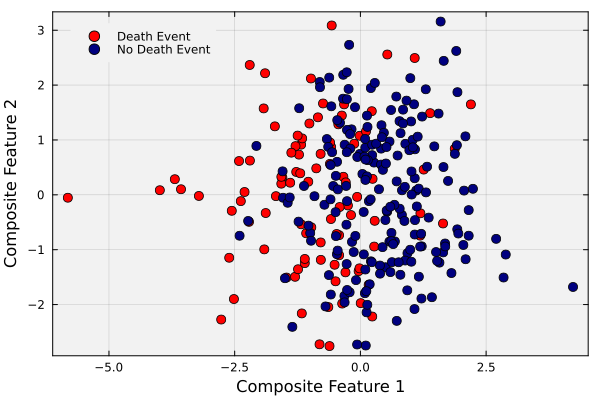

In [10]:
let

    # initialize -
    death_event = dataset[:, :death_event] |> Vector; # extract death_event labels
    
    # create scatter plot
    scatter([Y[death_event .== 1, 1]], [Y[death_event .== 1, 2]]; color=:red, label="Death Event", markersize=5)
    scatter!([Y[death_event .== -1, 1]], [Y[death_event .== -1, 2]]; color=:navy, label="No Death Event", markersize=5)

    # background, and labels
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("Composite Feature 1", fontsize=18)
    ylabel!("Composite Feature 2", fontsize=18)
end

In [11]:
do_I_see_the_PCA_plot = true; # TODO: update this flag {true | false}


> __Feature importance in PCA:__ 
> 
> The eigenvector coefficients indicate how much each of the original $m$ features contributes to a composite feature. For some eigenvector $\mathbf{z}$, the ith scaled component $l(\mathbf{z})_{i}$ is given by:
> $$
\begin{align*}
    l(\mathbf{z})_{i} &= \frac{\text{abs}(z_{i})}{\sum_{j=1}^{m}\text{abs}(z_{j})}\quad{i=1,2,\dots,m}
\end{align*}    
$$
> The scaled vectors should sum to `1`; thus, we can think about the elements (loosely) as probabilities, i.e., the probability that the ith component is the most important. 


Compute the scaled loadings for the first principal component.


In [ ]:
let    
    # initialize -
    k = 1; # look at only the first principal component
    ϕ = P[k,:]; # get the transformation vector
    df = DataFrame(); # allocate some space for the data in the table

    # compute the scaled loadings (abs value of the coefficients scaled by the sum)
    numerator = abs.(ϕ);
    denominator = sum(numerator);
    scaled_loadings = numerator ./ denominator;

    # Display feature importance
    feature_names = names(dataset)[1:end-1]; # exclude death_event column

    # compute the ordinal rankings of the scaled loadings
    p = sortperm(scaled_loadings, rev=true)          # indices in descending order
    r = similar(p)
    r[p] = 1:length(scaled_loadings)       # r[i] = ordinal rank of scaled_loadings[i]

    # let's populate the DataFrame so we can make a nice table -
    for i ∈ eachindex(feature_names)
        
        feature = feature_names[i];
        loading = scaled_loadings[i];
        rank = r[i];
        push!(df, (Feature=feature, Scaled_Loading=loading, Rank=rank));
    end

    # make a table -
    pretty_table(
        df;
        backend = :text,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------------------------- ---------------- -------
                   Feature   Scaled_Loading    Rank 
                    String          Float64   Int64 
 -------------------------- ---------------- -------
                       age         0.160962       2
                   anaemia        0.0850322       5
  creatinine_phosphokinase        0.0617763       8
                  diabetes        0.0635853       7
         ejection_fraction         0.036605      11
       high_blood_pressure        0.0600609       9
                 platelets        0.0654489       6
          serum_creatinine         0.137273       3
              serum_sodium         0.090957       4
                       sex        0.0476231      10
                   smoking        0.0273828      12
                      time         0.163294       1
 -------------------------- ---------------- -------


Next, we move to the perceptron classifier.

___

<a id="task2"></a>

## Task 2: Perceptron Classification using online learning
In this task, we build and train a [Perceptron](https://en.wikipedia.org/wiki/Perceptron) classifier using the training data, and then challenge this classifier using the `test` dataset. 

> __Convergence note:__ If the dataset $\mathcal{D}$ is linearly separable, the Perceptron converges to a separating hyperplane in finite iterations. If $\mathcal{D}$ is not linearly separable, the Perceptron may not converge. To avoid infinite loops, we set a maximum number of mistakes $M$ (e.g., $M=1$) and a maximum number of iterations $T$.

__Initialize__: Given a linearly separable dataset $\mathcal{D} = \left\{(\mathbf{x}_{1},y_{1}),\dotsc,(\mathbf{x}_{n},y_{n})\right\}$, the maximum number of iterations $T$, and the maximum number of mistakes $M$ (e.g., $M=1$), initialize the parameter vector $\mathbf{\theta} = \left(\mathbf{w}, b\right)$ to small random values and set the loop counter $t\gets{0}$.

> **Rule of thumb for maximum iterations**: Set the maximum number of iterations $T = 10n$ to $100n$, where $n$ is the number of training examples. The algorithm often converges faster for linearly separable data. However, for non-separable data, a larger $T$ may be necessary to achieve satisfactory performance.

While $\texttt{true}$ __do__:
1. Initialize the number of mistakes $\texttt{mistakes} = 0$.
2. For each training example $(\mathbf{x}, y) \in \mathcal{D}$: compute $y\;\left(\mathbf{\theta}^{\top}\;\mathbf{x}\right)\leq{0}$. 
    - If $\texttt{true}$: the example is __misclassified__ (the sign of the prediction doesn't match the label $y$). Update $\mathbf{\theta} \gets \mathbf{\theta} + y\;\mathbf{x}$ and increment $\texttt{mistakes} \gets \texttt{mistakes} + 1$.
3. After processing all examples, if $\texttt{mistakes} \leq {M}$ or $t \geq T$, exit. Otherwise, increment $t \gets t + 1$ and repeat from step 1.

We aim to minimize mistakes, with $M = 0$ being ideal. However, zero mistakes may not be achievable for weakly separable or non-separable data.

__Training__: Our Perceptron implementation stores problem data in a [MyPerceptronClassificationModel instance](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyPerceptronClassificationModel). We learn parameters using the [learn(...) method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.learn), which takes the feature array `X`, labels vector `y`, and problem instance, returning an updated instance with the learned parameters. The trained classifier is stored in `model_perceptron::MyPerceptronClassificationModel`.

Train the perceptron model on the training set.


In [13]:
model_perceptron = let

    # data -
    X = training.X; # input matrix
    y = training.y; # output vector
    number_of_examples = size(X,1); # how many examples do we have (rows)
    number_of_features = size(X,2); # how many features do we have (cols)?
    maxiter = 100*number_of_examples; # maximum number of iterations

    # model
    model = build(MyPerceptronClassificationModel, (
        parameters = ones(number_of_features), # initial value for the parameters: these will be updated
        mistakes = 0 # willing to live with m mistakes
    ));

    # train -
    model = learn(X,y,model, maxiter = maxiter, verbose = true);

    # return -
    model;
end;

Stopped after number of iterations: 23900. We have number of errors: 62


Now we evaluate the trained model on unseen test data.

> __Inference__ 
> 
> We run classification on test data using the [classify(...) method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.classify). This takes the feature array `X` and trained model, returning estimated labels. We store actual labels in `y_perceptron::Vector{Float64}` and predicted labels in `ŷ_perceptron::Vector{Float64}`.

Run inference on the test set to obtain predicted labels.

In [14]:
ŷ_perceptron,y_perceptron = let

    X = test.X; # what dataset are going to use?
    y = test.y; # what are the actual labels?
    number_of_examples = size(X,1); # how many examples do we have (rows)
    number_of_features = size(X,2); # how many features do we have (cols)?

    # compute the estimated labels -
    ŷ = classify(X,model_perceptron);

    # return -
    ŷ,y
end;

Before computing the full confusion matrix, we tally the raw number of misclassified test examples in `number_of_prediction_mistakes::Int64` and print the overall mistake percentage.

In [15]:
number_of_prediction_mistakes = let

    # initialize -
    number_of_test_examples = length(ŷ_perceptron);
    error_counter = 0;

    for i ∈ 1:number_of_test_examples
        if (ŷ_perceptron[i] != y_perceptron[i])
            error_counter += 1;
        end
    end
    
    # print the number of mistakes -
    println("Number of Perceptron mistakes: $(error_counter) of $(length(ŷ_perceptron)) test examples.")

    error_counter # return the number of prediction mistakes
end;

Number of Perceptron mistakes: 15 of 60 test examples.


In [16]:
println("Perceptron mistake percentage: $((number_of_prediction_mistakes/length(ŷ_perceptron))*100)%")

Perceptron mistake percentage: 25.0%


Beyond the raw mistake count, we evaluate classifier performance using [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix compares predicted labels $\hat{y}_{i}$ to actual labels $y_{i}$ and categorizes each prediction as a true positive, true negative, false positive, or false negative.

> **Error analysis using the confusion matrix**
>
> Total mistakes alone do not reveal *where* the classifier fails. In a clinical setting, we need to distinguish: How often did we predict death when the patient survived (false positive)? How often did we predict survival when the patient died (false negative)?
>
> The confusion matrix for a binary classifier:
>
>|                     | **Predicted Positive** | **Predicted Negative** |
>|---------------------|------------------------|------------------------|
>| **Actual Positive** | True Positive (TP)     | False Negative (FN)    |
>| **Actual Negative** | False Positive (FP)    | True Negative (TN)     |
>
> From these counts we derive three metrics:
>
> * **Accuracy** is the fraction of correct predictions: $\texttt{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$. It can mislead on imbalanced data; a classifier that always predicts "survived" could score high if most patients survived.
>
> * **Precision** answers "when we predict death, how often are we right?" $\texttt{precision} = \frac{TP}{TP + FP}$. High precision means fewer false alarms.
>
> * **Recall** (sensitivity) answers "of all patients who died, how many did we catch?" $\texttt{recall} = \frac{TP}{TP + FN}$. In diagnosis, recall is often more critical; missing a death is worse than a false alarm.

Compute the confusion matrix and store it in `CM_perceptron::Array{Int64,2}`, then extract `accuracy_perceptron::Float64`, `precision_perceptron::Float64`, and `recall_perceptron::Float64`.

In [17]:
CM_perceptron = confusion(y_perceptron,ŷ_perceptron) # important: actual labels first, estimated labels second

2×2 Matrix{Int64}:
 12   9
  6  33

In [18]:
accuracy_perceptron, precision_perceptron, recall_perceptron = let

    # extract confusion matrix values -
    TP = CM_perceptron[1,1]; # true positives
    TN = CM_perceptron[2,2]; # true negatives
    FP = CM_perceptron[2,1]; # false positives
    FN = CM_perceptron[1,2]; # false negatives

    # compute metrics -
    accuracy = (TP + TN) / (TP + TN + FP + FN); # accuracy
    precision = TP / (TP + FP); # precision
    recall = TP / (TP + FN); # recall

    # print so the user can see -
    println("Perceptron Accuracy: $(round(accuracy*100,digits=2))%")
    println("Perceptron Precision: $(round(precision*100,digits=2))%")
    println("Perceptron Recall: $(round(recall*100,digits=2))%")

    # return -
    accuracy, precision, recall
end;

Perceptron Accuracy: 75.0%
Perceptron Precision: 66.67%
Perceptron Recall: 57.14%


___

<a id="task3"></a>

## Task 3: Logistic Regression using Gradient Descent
In this task, we build and train a [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) classifier using the training data, and then challenge this classifier using the `test` dataset. We'll use [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) to minimize the negative log-likelihood loss function. A [pseudocode outline of our training algorithm can be found here](docs/CHEME-5820-Algorithm-Simplified-GD-Spring-2026.ipynb).

We implemented [the `MyLogisticRegressionClassificationModel` type](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/), which contains data required to solve the logistic regression problem, i.e., parameters, the learning rate, a stopping tolerance parameter $\epsilon$, and a loss (objective) function that we want to minimize.

Convergence uses the tolerance $\epsilon$ on parameter change: stop when $\|\theta^{(t)}-\theta^{(t-1)}\|_{2} \le \epsilon$.

> __Details__
> 
> * __Technical note__: In this implementation, we approximate the gradient using a forward finite difference.
> * __Note on the loss function__: In the code below, we use the natural logarithm `log` in the loss function. You could also use `log10`. While this differs from the mathematical derivation above (which uses natural log), it does not change the location of the minimum since `log10` is simply a scaled version of the natural log. The gradient descent algorithm will find the same optimal parameters $\theta$.
> * In the code block below, we [build a `model::MyLogisticRegressionClassificationModel` instance using a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/). The model instance initially has a random guess for the classifier parameters. We use gradient descent to refine that guess [using the `learn(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/), which returns an updated model instance (with the best parameters that we found so far). 

We return the updated model instance and save it in the `model_logistic_gd::MyLogisticRegressionClassificationModel` variable.


In [19]:
model_logistic_gd = let

    # data -
    X = training.X; # feature matrix
    y = training.y; # labels
    number_of_features = size(X,2); # number of features + 1
    T = 1.0; # inverse temperature (called β in the math) for logistic regression
    h = 1e-6; # step size for finite difference gradient approximation
    λ = 0.0; # regularization parameter
    ϵ = 1e-6; # tolerance for convergence

    # model
    model = build(MyLogisticRegressionClassificationModel, (
        parameters = 0.01*ones(number_of_features), # initial value for the parameters: these will be updated
        learning_rate = 0.005, # you pick this
        ϵ = ϵ, # you pick this (this is the tolerance for convergence)
        h = h, # you pick this (this is the step size for finite difference gradient approximation)
        λ = λ, # regularization parameter
        T = T, # inverse temperature (called β in the math) for logistic regression
        loss_function = (x,y,T,λ,θ) -> log(1+exp(-2*y*T*(dot(x,θ)))) + λ*norm(θ,2)^2 # cross-entropy loss with L2 regularization
    ));

    # train -
    model = learn(X,y,model, maxiter = 20000, verbose = true); # this is learning the model parameters

    # return -
    model;
end;

Stopped after number of iterations: 88. We have error: 9.794091128141845e-7


Now we test how well the trained `model_logistic_gd::MyLogisticRegressionClassificationModel` instance classifies data it has never seen, i.e., the `test` dataset.

> __Inference__: We run classification on the test data [using the `classify(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/). Unlike the Perceptron, logistic regression returns class probabilities: each row of the output matrix is a test instance and each column corresponds to a label (`1` or `-1`). We convert these to hard predictions by selecting the highest-probability class.

We store the predicted labels in `ŷ_logistic_gd::Vector{Float64}`, the actual labels in `y_logistic_gd::Vector{Float64}`, and the raw class probabilities in `probability_matrix::Array{Float64,2}`.

In [ ]:
ŷ_logistic_gd,y_logistic_gd, probability_matrix = let

    D = test.X; # What dataset are you going to use?
    y = test.y; # what are the actual labels?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?

    # compute the estimated labels -
    P = classify(D, model_logistic_gd) # logistic regression returns an n x 2 array holding the probability

    # convert the probability to a choice ... for each row (test instance), compute the col with the highest probability
    ŷ = zeros(number_of_examples);
    for i ∈ 1:number_of_examples
        a = argmax(P[i,:]); # col index with largest value
        ŷ[i] = 1; # default
        if (a == 2)
            ŷ[i] = -1;
        end
    end
    
    # return -
    ŷ, y, P
end;

We evaluate the logistic regression classifier using the same confusion-matrix framework introduced in Task 2. Although logistic regression outputs class probabilities rather than hard labels, we converted these to predictions in the previous cell by selecting the highest-probability class.

Compute the confusion matrix and store it in `CM_logistic_gd::Array{Int64,2}`, then extract `accuracy_logistic::Float64`, `precision_logistic::Float64`, and `recall_logistic::Float64`.

In [21]:
CM_logistic_gd = confusion(y_logistic_gd, ŷ_logistic_gd) # actual, predicted

2×2 Matrix{Int64}:
 15   6
  5  34

In [22]:
accuracy_logistic, precision_logistic, recall_logistic = let

    # extract confusion matrix values -
    TP = CM_logistic_gd[1,1]; # true positives
    TN = CM_logistic_gd[2,2]; # true negatives
    FP = CM_logistic_gd[2,1]; # false positives
    FN = CM_logistic_gd[1,2]; # false negatives

    # compute metrics -
    accuracy = (TP + TN) / (TP + TN + FP + FN); # accuracy
    precision = TP / (TP + FP); # precision
    recall = TP / (TP + FN); # recall

    # print so the user can see -
    println("Logistic Regression Accuracy: $(round(accuracy*100,digits=2))%")
    println("Logistic Regression Precision: $(round(precision*100,digits=2))%")
    println("Logistic Regression Recall: $(round(recall*100,digits=2))%")

    # return -
    accuracy, precision, recall
end;

Logistic Regression Accuracy: 81.67%
Logistic Regression Precision: 75.0%
Logistic Regression Recall: 71.43%


What does `probability_matrix::Array{Float64,2}` look like? If the classification is confident, probabilities will be close to 0 or 1; if uncertain, they will cluster near 0.5. The first column corresponds to the probability of class `1` and the second column to class `-1`.

In [23]:
probability_matrix

60×2 Matrix{Float64}:
 0.0259703   0.97403
 0.00772368  0.992276
 0.548683    0.451317
 0.327167    0.672833
 0.0204115   0.979589
 0.0103858   0.989614
 0.522458    0.477542
 0.0719435   0.928057
 0.764919    0.235081
 0.0598123   0.940188
 ⋮           
 0.166464    0.833536
 0.0472535   0.952746
 0.0091105   0.99089
 0.140405    0.859595
 0.0180373   0.981963
 0.0859835   0.914017
 0.645574    0.354426
 0.953226    0.0467738
 0.38943     0.61057

___

<a id="discussion"></a>

## Discussion
We now have two trained classifiers for the same clinical prediction task. The tables below compare their confusion-matrix entries and learned parameters side by side. Use these comparisons to answer the discussion questions that follow.

In [24]:
let
    df = DataFrame();

    # GD -
    push!(df, (
        label = "Logistic Regression (GD)",
        TP = CM_logistic_gd[1,1],
        FN = CM_logistic_gd[1,2],
        FP = CM_logistic_gd[2,1],
        TN = CM_logistic_gd[2,2],
        Accuracy = round(accuracy_logistic, digits=4),
        Precision = round(precision_logistic, digits=4),
        Recall = round(recall_logistic, digits=4)
    ))

    # Perceptron -
    push!(df, (
        label = "Perceptron",
        TP = CM_perceptron[1,1],
        FN = CM_perceptron[1,2],
        FP = CM_perceptron[2,1],
        TN = CM_perceptron[2,2],
        Accuracy = round(accuracy_perceptron, digits=4),
        Precision = round(precision_perceptron, digits=4),
        Recall = round(recall_perceptron, digits=4)
    ))

    # make a table -
    pretty_table(
        df;
        backend = :text,
        fit_table_in_display_horizontally = false,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------------------------- ------- ------- ------- ------- ---------- ----------- ---------
                     label      TP      FN      FP      TN   Accuracy   Precision    Recall 
                    String   Int64   Int64   Int64   Int64    Float64     Float64   Float64 
 -------------------------- ------- ------- ------- ------- ---------- ----------- ---------
  Logistic Regression (GD)      15       6       5      34     0.8167        0.75    0.7143
                Perceptron      12       9       6      33       0.75      0.6667    0.5714
 -------------------------- ------- ------- ------- ------- ---------- ----------- ---------


In [25]:
do_I_see_confusion_table = true; # TODO: update this flag {true | false}

Next, compare the parameter values estimated by the perceptron and logistic regression models. The `abs_p_diff` field denotes the absolute percentage difference from the perceptron parameters.

In [26]:
let
    df = DataFrame();
    θ₁ = model_perceptron.β;
    θ₂ = model_logistic_gd.β;
    number_of_parameters = length(θ₁);

    for i ∈ 1:number_of_parameters
        row_df = (
            parameter_index = i,
            Perceptron = θ₁[i],
            Logistic = θ₂[i],
            abs_p_diff = 100*abs((θ₁[i] - θ₂[i])/θ₁[i])
        );
        push!(df, row_df);
    end

    pretty_table(
        df;
        backend = :text,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 ----------------- ------------ ------------- ------------
  parameter_index   Perceptron      Logistic   abs_p_diff 
            Int64      Float64       Float64      Float64 
 ----------------- ------------ ------------- ------------
                1      3.58955      0.345228      90.3824
                2     -2.95987    -0.0129921      99.5611
                3    -0.735695       0.15912      121.629
                4     -1.14716   -0.00464549       99.595
                5     -2.75288     -0.509829      81.4802
                6     -2.08361    -0.0497166      97.6139
                7     -2.13551      0.022707      101.063
                8      2.87254      0.391817      86.3599
                9      -2.3138     -0.189359      91.8161
               10     0.083612      -0.13689       263.72
               11    -0.505017    -0.0111941      97.7834
               12     -6.03704     -0.799125       86.763
               13         -6.0     -0.693191      88.4468
 ---------

In [27]:
do_I_see_parameter_table = true; # TODO: update this flag {true | false}

**DQ1: Which classifier would you deploy for mortality screening?** The comparison table above shows confusion-matrix entries and metrics for both models on the same test split. In a clinical setting, missing a patient who will die (false negative) and flagging a healthy patient for urgent follow-up (false positive) carry very different costs.

> __Strategy__: Using the accuracy, precision, and recall values from the table, state which classifier you would choose for this dataset. Justify your choice in 2–3 sentences, explicitly addressing whether you prioritize precision or recall for a mortality screening task and why.

In [28]:
# Answer DQ1 here after running the models and recording metrics.

In [29]:
did_I_answer_DQ1 = true; # TODO: update to true if answered DQ1 {true | false}

**DQ2: How does the inverse temperature $\beta$ affect clinical predictions?** In the logistic regression loss function, the inverse temperature (called `T` in the code) controls how sharply the model separates classes. A small `T` produces soft, uncertain probabilities; a large `T` pushes probabilities toward 0 or 1.

> __Strategy:__ Change `T` in the logistic regression training cell to at least three values (e.g., $2^{-2}$, $2^{0}$, $2^{2}$), re-run the training and inference cells each time, and record the accuracy, precision, and recall. How do these metrics shift as `T` increases? Which value of `T` would you choose for this clinical task, and does the answer depend on whether you prioritize catching all deaths (recall) versus avoiding false alarms (precision)? Explain in 2–3 sentences.

In [30]:
# Answer DQ2 here after sweeping `T` and recording metrics.

In [31]:
did_I_answer_DQ2 = true; # TODO: update to true if answered DQ2 {true | false}

**DQ3: How does regularization $\lambda$ affect the learned weights and test performance?** The L2 regularization term $\lambda\|\boldsymbol{\theta}\|_{2}^{2}$ penalizes large weights, trading off training-set fit against generalization. Over-regularizing can force the model to ignore risk factors that genuinely predict mortality.

> __Strategy:__ Reset `T` to `1.0`, then change `λ` in the logistic regression training cell to at least three values (e.g., $0$, $10^{-2}$, $10^{-1}$). Re-run training and check both the test metrics and the parameter comparison table. How do the weight magnitudes and classification metrics change as $\lambda$ increases? At what point does regularization start to hurt test performance, and what does that tell you about the complexity needed for this dataset? Explain in 2–3 sentences.

In [32]:
# Answer DQ3 here after sweeping `\lambda` and recording metrics.

In [33]:
did_I_answer_DQ3 = true; # TODO: update to true if answered DQ3 {true | false}

**DQ4: Do PCA, the perceptron, and logistic regression agree on which clinical features matter?** The PCA loadings table in Task 1 ranks features by their contribution to the first principal component. The parameter comparison table above shows the learned weights for both classifiers. Different methods can emphasize different features depending on their objective; PCA maximizes variance, while the classifiers minimize prediction error.

> __Strategy:__ Compare the top-3 features identified by PCA loadings, the perceptron weights, and the logistic regression weights (use absolute values for a fair comparison). Where do the rankings agree, and where do they diverge? [Chicco and Jurman (2020)](https://pubmed.ncbi.nlm.nih.gov/32013925/) found that serum creatinine and ejection fraction alone could predict survival; do your three methods support that finding? Discuss in 3–4 sentences.

In [34]:
# Answer DQ4 here after computing feature rankings across methods.

In [35]:
did_I_answer_DQ4 = true; # TODO: update to true if answered DQ4 {true | false}

___

<a id="summary"></a>

## Summary
We investigated whether routine clinical risk factors can predict heart-failure mortality using two linear classifiers. After preprocessing the 299-patient dataset (binary recoding and z-score normalization), PCA visualization revealed the degree of class overlap in two dimensions, and both the perceptron and logistic regression were trained and evaluated on the same 80/20 split.

> __Key Takeaways:__
>
> * **Preprocessing determines model input quality:** Recoding binary features to $\{-1,1\}$ and z-score scaling continuous features places all inputs on comparable scales for gradient-based learning.
> * **PCA reveals class separability before training:** Projecting onto the top two eigenvectors provides a visual check of whether the classes are likely separable by a linear boundary.
> * **Confusion-matrix metrics expose different failure modes:** Accuracy alone can hide class imbalance; precision and recall reveal whether the classifier is biased toward false positives or false negatives, a critical distinction for clinical deployment.

This exercise illustrates the end-to-end process of building and evaluating linear classifiers on a real clinical dataset, highlighting the importance of preprocessing, visualization, and nuanced performance metrics in machine learning for healthcare.

___

<a id="tests"></a>

## Tests
In the code block below, we check some values in your notebook and give you feedback on which items are correct or different. `Unhide` the code block below (if you are curious) about how we implemented the tests and what we are testing.

In [36]:
let 
    @testset verbose = true "CHEME 5820 problem set 2 test suite" begin
        
        @testset "Setup, Prerequisites and Data" begin
            @test _DID_INCLUDE_FILE_GET_CALLED == true
            @test isnothing(X) == false
            @test isnothing(y) == false
            @test isnothing(dataset) == false
            @test isempty(Σ̂) == false
            @test size(X,1) == length(y)
            @test size(dataset,1) == size(X,1)
            @test all(v -> v in (-1.0, 1.0), y)
        end

        @testset "Task 1: PCA" begin
            @test isnothing(P) == false
            @test isnothing(Y) == false
            @test size(Y,1) == size(X̃,1)
            @test size(Y,2) == 2
            @test size(P,1) == 2
            @test size(P,2) == size(X,2)
            @test maximum(abs.(mean(X̃, dims=1))) < 1e-8
            @test isapprox(Σ̂, transpose(Σ̂), atol=1e-8)
            @test minimum(eigvals(Σ̂)) >= -1e-8
            @test isapprox(P * transpose(P), I(2), atol=1e-6)
            @test isapprox(Y, X̃ * transpose(P), atol=1e-8)
            @test do_I_see_the_PCA_plot == true
        end

        @testset "Task 2: Logistic Regression using Gradient Descent" begin
            @test isnothing(model_logistic_gd) == false
            @test length(ŷ_logistic_gd) == size(test.X,1);
            @test isnothing(CM_logistic_gd) == false
            @test size(CM_logistic_gd,1) == 2
            @test size(CM_logistic_gd,2) == 2
            @test all(CM_logistic_gd .>= 0)
            @test sum(CM_logistic_gd) == length(y_logistic_gd)
            @test (CM_logistic_gd[1,1] + CM_logistic_gd[2,1]) > 0
            @test (CM_logistic_gd[1,1] + CM_logistic_gd[1,2]) > 0
            @test 0.0 <= accuracy_logistic <= 1.0
            @test 0.0 <= precision_logistic <= 1.0
            @test 0.0 <= recall_logistic <= 1.0
        end

        @testset "Task 2: Perceptron" begin
            @test isnothing(model_perceptron) == false
            @test length(ŷ_perceptron) == size(test.X,1);
            @test isnothing(CM_perceptron) == false
            @test size(CM_perceptron,1) == 2
            @test size(CM_perceptron,2) == 2
            @test all(CM_perceptron .>= 0)
            @test sum(CM_perceptron) == length(y_perceptron)
            @test (CM_perceptron[1,1] + CM_perceptron[2,1]) > 0
            @test (CM_perceptron[1,1] + CM_perceptron[1,2]) > 0
            @test 0.0 <= accuracy_perceptron <= 1.0
            @test 0.0 <= precision_perceptron <= 1.0
            @test 0.0 <= recall_perceptron <= 1.0
        end

        @testset "Discussion questions" begin
            @test do_I_see_confusion_table == true
            @test do_I_see_parameter_table == true
            @test did_I_answer_DQ1 == true
            @test did_I_answer_DQ2 == true
            @test did_I_answer_DQ3 == true
            @test did_I_answer_DQ4 == true
        end
    end
end;

Test Summary:                                        | Pass  Total  Time
CHEME 5820 problem set 2 test suite                  |   50     50  0.7s
  Setup, Prerequisites and Data                      |    8      8  0.3s
  Task 1: PCA                                        |   12     12  0.3s
  Task 2: Logistic Regression using Gradient Descent |   12     12  0.0s
  Task 2: Perceptron                                 |   12     12  0.0s
  Discussion questions                               |    6      6  0.0s
